# SHAP contribution analysis for trial outcomes

Use surrogate models and SHAP to understand which patient-level variables most influence trial outcomes.  
This approach is model-agnostic, captures interaction effects, and supports both global and patient-level interpretability.

**References**
- SHAP documentation: https://shap.readthedocs.io/en/latest/api.html
- Practical guide to SHAP analysis (2023): https://ascpt.onlinelibrary.wiley.com/doi/10.1111/cts.70056


In [75]:
# Jinko specifics imports & initialization
# Please fold this section and do not change
import jinko_helpers as jinko

# Connect to Jinko (see README.md for more options)
jinko.initialize()

In [76]:
# Cookbook specific imports
import json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

## Step 1: Load the trial

We load the latest completed trial version and retrieve patient-level descriptors and outputs for a single scalar outcome of interest.


In [77]:
# The trial's short id can be retrieved in the url, pattern is `https://jinko.ai/<trial_sid>`
TRIAL_SID = "tr-0qYI-s3rF"

# Convert short id to core item id
trial_core_item_id = jinko.get_core_item_id(TRIAL_SID, 1)

# List all trial versions
# https://doc.jinko.ai/api/#/paths/core-v2-trial_manager-trial-trialId--status/get
response = jinko.make_request(
    f'/core/v2/trial_manager/trial/{trial_core_item_id["id"]}/status'
)
versions = response.json()

# Get the latest completed version
try:
    latest_completed_version = next(
        (item for item in versions if item["status"] == "completed"),
        None,
    )
    if latest_completed_version is None:
        raise ValueError("No completed trial version found")

    print(
        "Successfully fetched this simulation:",
        json.dumps(latest_completed_version, indent=4),
    )
    simulation_id = latest_completed_version["simulationId"]
    trial_core_item_id = simulation_id["coreItemId"]
    trial_snapshot_id = simulation_id["snapshotId"]
except Exception as exc:
    print(f"Error processing trial versions: {exc}")

response_summary = jinko.get_trial_scalars_summary(
    trial_core_item_id,
    trial_snapshot_id,
    print_summary=True,
)

Successfully fetched this simulation: {
    "creationDate": "2025-12-23T16:24:42.311458Z",
    "simulationId": {
        "coreItemId": "9d061f82-cc12-41b0-8137-320f67823c90",
        "snapshotId": "b788ab0e-e2d5-4c44-9e4c-6aff75e264ac"
    },
    "status": "completed"
}
Number of patients: 1000

Available arms: ['iv-1-10']

Available scalars:
 ['Blood.Drug.auc', 'Blood.Drug.max', 'Blood.Drug.mean', 'Blood.Drug.min', 'Blood.Drug.tend', 'Blood.Drug.timeofmax', 'SimulationTMax', 'SimulationTMin', 'Tissue.Drug.auc', 'Tissue.Drug.max', 'Tissue.Drug.mean', 'Tissue.Drug.min', 'Tissue.Drug.tend', 'Tissue.Drug.timeofmax', 'Tumor.CancerCell.auc', 'Tumor.CancerCell.max', 'Tumor.CancerCell.mean', 'Tumor.CancerCell.min', 'Tumor.CancerCell.tend', 'Tumor.CancerCell.timeofmax', 'Tumor.Drug.auc', 'Tumor.Drug.max', 'Tumor.Drug.mean', 'Tumor.Drug.min', 'Tumor.Drug.tend', 'Tumor.Drug.timeofmax', '__jinkoAllocationMiB.tmax', '__jinkoSolvingTime.tmax', 'dose.tmin', 'fullDose.tmin', 'isResponse.auc', 'isResp

## Step 2: Load patient-level descriptors and outputs

We select one output scalar to model: `TARGET_QOI` on one arm.

The features are the baseline inputs of the model, we get them from the jinko Tornado route.

We use `crossArms` as the baseline arm for input descriptors, then copy those inputs to the target arm so outputs remain arm-specific.


In [78]:
TARGET_QOI = "tumorBurdenChangeFromBaseline.tend"
TARGET_ARM = "iv-1-10"

In [79]:
# all Basline Input descriptors will be taken into account as features

def get_features(trial_summary):
    scalars_cross_arm = trial_summary.get('scalarsCrossArm', [])

    def is_baseline_input(scalar):
        t = scalar.get('type') or {}
        return (
            t.get('type') == 'BaselineInput'
            and 'ScenarioOverride' not in (t.get('labels') or [])
        )
    return [s.get('id') for s in scalars_cross_arm if is_baseline_input(s)]


feature_cols = get_features(response_summary)
print("Input Baseline Features:")
for f in feature_cols:
    print(f"  - {f}")

Input Baseline Features:
  - Blood.Drug.tmin
  - Blood.tmin
  - Lymph.Drug.tmin
  - Lymph.tmin
  - SubcutaneousInjectionSite.Drug.tmin
  - SubcutaneousInjectionSite.tmin
  - Tissue.Drug.tmin
  - Tissue.tmin
  - Tumor.Drug.tmin
  - bloodFlowRate.tmin
  - ec50Drug.tmin
  - initialTumorBurden.tmin
  - kClearanceDrug.tmin
  - kGrowthCancerCell.tmin
  - kccCancerCell.tmin
  - lymphDrainingRate.tmin
  - vmaxCancerCellDeath.tmin


In [80]:
# Loading scalars into a dataframe (long format)
df_scalars = jinko.get_trial_scalars_as_dataframe(
    trial_core_item_id,
    trial_snapshot_id,
    scalar_ids=feature_cols + [TARGET_QOI],
)

# Pivot to wide format: one row per patient, one column per scalar
wide_df = (
    df_scalars.pivot_table(
        index=["patientId", "armId"],
        columns="scalarId",
        values="value",
        aggfunc="first",
    )
    .reset_index()
)

# Ensure numeric columns are numeric
for col in feature_cols + [TARGET_QOI]:
    if col in wide_df.columns:
        wide_df[col] = pd.to_numeric(wide_df[col], errors="coerce")

# Use baseline inputs from crossArms for all arms (same across arms)
baseline_arm = "crossArms"
feature_cols = [c for c in feature_cols if c in wide_df.columns]

baseline_df = (
    wide_df[wide_df["armId"] == baseline_arm][["patientId"] + feature_cols]
    .set_index("patientId")
)

for col in feature_cols:
    wide_df[col] = wide_df[col].fillna(
        wide_df["patientId"].map(baseline_df[col])
    )

# Focus analysis on a single arm for the output
arm_df = wide_df[wide_df["armId"] == TARGET_ARM].copy()
print(f"Using target arm: {TARGET_ARM}")

# Keep only rows with a target value (arm-specific outputs)
df_scalars = arm_df.dropna(subset=[TARGET_QOI]).copy()

# Fill any remaining missing features with median values, skipping columns with all NaNs
for col in feature_cols:
    median_val = df_scalars[col].median()
    if pd.isna(median_val):
        print(f"Warning: all values are NaN for {col}, dropping this feature")
        df_scalars = df_scalars.drop(columns=[col])
        continue
    df_scalars.loc[:, col] = df_scalars[col].fillna(median_val)

# Update feature_cols to match remaining columns
feature_cols = [c for c in feature_cols if c in df_scalars.columns]

print("Filtered scalar data (first rows):")
display(df_scalars.head())
print("Number of patients:", len(df_scalars))

Using target arm: iv-1-10
Filtered scalar data (first rows):


scalarId,patientId,armId,Blood.Drug.tmin,Blood.tmin,Lymph.Drug.tmin,Lymph.tmin,SubcutaneousInjectionSite.Drug.tmin,SubcutaneousInjectionSite.tmin,Tissue.Drug.tmin,Tissue.tmin,Tumor.Drug.tmin,bloodFlowRate.tmin,ec50Drug.tmin,initialTumorBurden.tmin,kClearanceDrug.tmin,kGrowthCancerCell.tmin,kccCancerCell.tmin,lymphDrainingRate.tmin,tumorBurdenChangeFromBaseline.tend,vmaxCancerCellDeath.tmin
1,002cfb8c-8277-b2da-ce8a-4f8006a24e9d,iv-1-10,0.0,0.839478,0.0,0.353245,0.0,9.025549,0.0,0.538319,0.0,104.975871,0.001099,77.883735,0.079562,0.000738,2.034547e+13,0.119818,-15.332456,0.011681
3,00a1695e-e4d4-5b88-f8f0-59327b61a5c1,iv-1-10,0.0,0.897154,0.0,0.357139,0.0,11.268139,0.0,0.419092,0.0,99.042737,0.001072,50.866036,0.076683,0.001238,8.066072e+11,0.095753,36.438381,0.008074
5,00b9a4e5-03b3-7e67-2480-0de5d6a1f7ea,iv-1-10,0.0,0.979331,0.0,0.257337,0.0,8.723177,0.0,0.501080,0.0,106.948158,0.001300,75.083188,0.085076,0.000926,4.692348e+11,0.097431,0.901504,0.012215
7,00c13880-7ee0-3a95-a955-f75add9f82e0,iv-1-10,0.0,0.945526,0.0,0.313139,0.0,8.244636,0.0,0.545231,0.0,102.944436,0.001120,61.651524,0.069724,0.000936,9.948849e+11,0.119998,11.557618,0.009645
9,00cef0ad-b0c8-c571-0eb2-1f25ead8803e,iv-1-10,0.0,1.077521,0.0,0.359309,0.0,10.519979,0.0,0.427048,0.0,89.982712,0.001107,75.649874,0.077161,0.001145,1.929488e+12,0.088461,15.543118,0.009767


Number of patients: 999


We use histograms for both baseline inputs and the target output to show the full shape of each distribution.


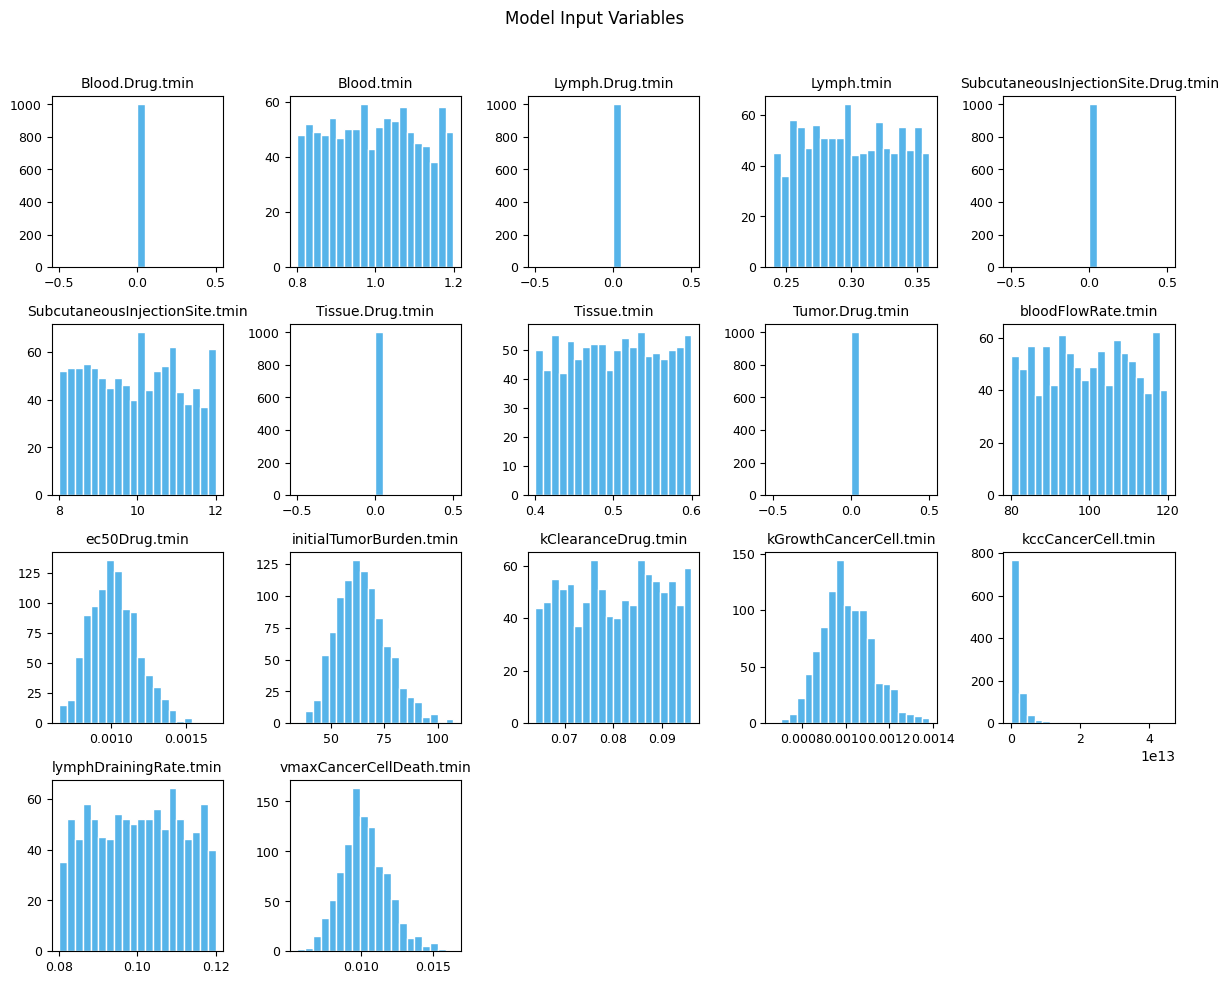

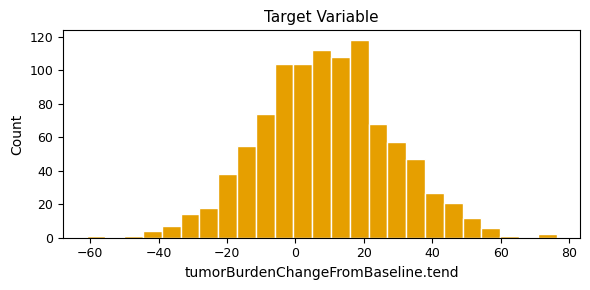

In [81]:
# Plot feature distributions and target distribution
n_features = len(feature_cols)
ncols = 5
nrows = int(np.ceil(n_features / ncols)) if n_features else 1

# Feature histograms (separate figure to maximize usable space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2.4 * nrows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    ax.hist(df_scalars[col].dropna(), bins=20,
            color="#56b4e9", edgecolor="white")
    ax.set_title(col, fontsize=10)
    ax.tick_params(labelsize=9)

for ax in axes[n_features:]:
    ax.axis("off")

fig.suptitle("Model Input Variables", y=1.02, fontsize=12)
fig.tight_layout()

# Target distribution (histogram)
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_scalars[TARGET_QOI].dropna(), bins=25,
        color="#e69f00", edgecolor="white")
ax.set_title("Target Variable", fontsize=11)
ax.set_xlabel(TARGET_QOI, fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.tick_params(labelsize=9)
fig.tight_layout()

## Step 3: Train a surrogate model

We train a tree-based surrogate model to approximate the simulation outputs. Tree models work well with SHAP's TreeExplainer.

We compare a few surrogate models and keep the best R2 on a holdout split.


Model comparison:


,model,r2,mae
1,hist_gb,0.923156,3.880179
0,random_forest,0.796599,6.315872


Selected model: hist_gb
R2: 0.923
MAE: 3.880


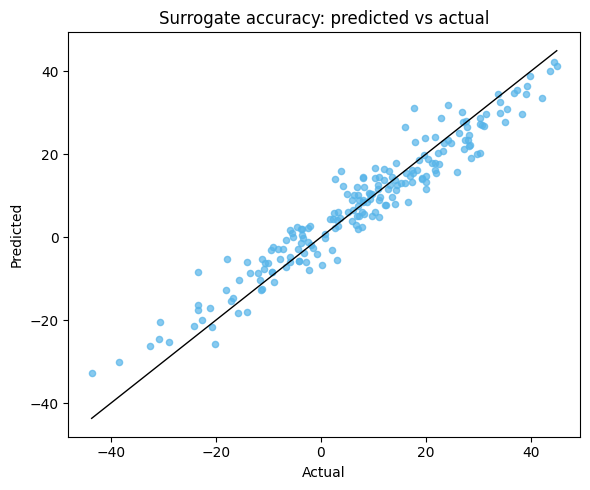

In [82]:
X = df_scalars[feature_cols]
y = df_scalars[TARGET_QOI]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Models: RandomForest, HistGradientBoosting
models = {
    "random_forest": RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        random_state=0,
        n_jobs=-1,
    ),
    "hist_gb": HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=500,
        random_state=0,
    ),
}

# Pick the best surrogate on a holdout split (R2)
results = []
best_model = None
best_r2 = -1e9
for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results.append({"model": name, "r2": r2, "mae": mae})
    if r2 > best_r2:
        best_r2 = r2
        best_model = m
        best_preds = preds

results_df = pd.DataFrame(results).sort_values("r2", ascending=False)
print("Model comparison:")
display(results_df)

model = best_model
y_pred = best_preds
print(f"Selected model: {results_df.iloc[0]['model']}")
print(f"R2: {best_r2:.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# Surrogate accuracy plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(y_test, y_pred, s=20, alpha=0.7, color="#56b4e9")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1)
ax.set_title("Surrogate accuracy: predicted vs actual")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
plt.tight_layout()

## Step 4: SHAP analysis (Population-level + Individual-level)

We compute SHAP values for both population-level feature importance and individual-level explanations.

Individual-level results are shown for a selected patient, specifically the first row (idx = 0).

For guidance on interpreting summary and beeswarm plots, see: https://ascpt.onlinelibrary.wiley.com/doi/10.1111/cts.70056

SHAP values are computed on the selected surrogate model to explain the simulator outputs.


SHAP global importance (top 10):


,feature,mean_abs_shap
0,initialTumorBurden.tmin,6.310113
1,vmaxCancerCellDeath.tmin,5.136124
2,ec50Drug.tmin,4.904022
3,kccCancerCell.tmin,4.578975
4,kGrowthCancerCell.tmin,4.216538
5,kClearanceDrug.tmin,4.014624
6,Blood.tmin,3.538668
7,Tissue.tmin,3.301621
8,SubcutaneousInjectionSite.tmin,0.166571
9,bloodFlowRate.tmin,0.156323


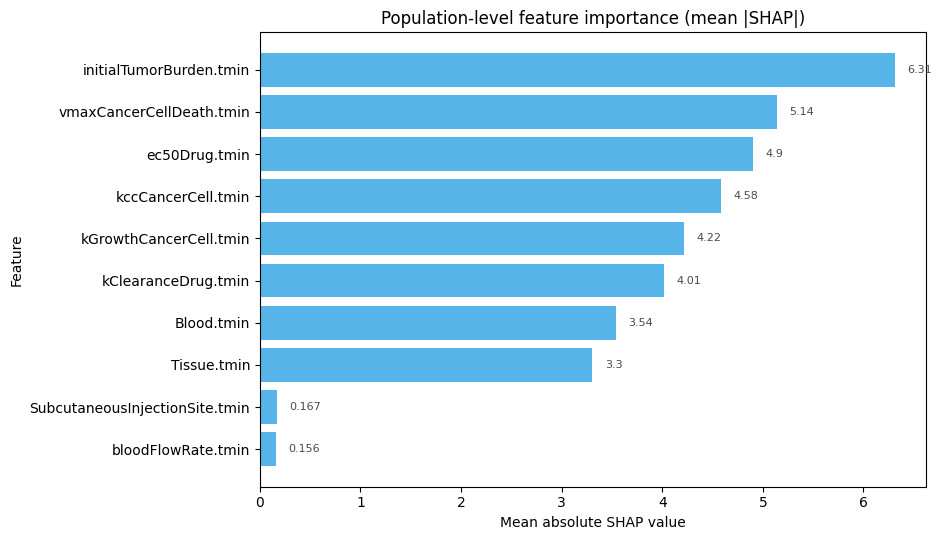

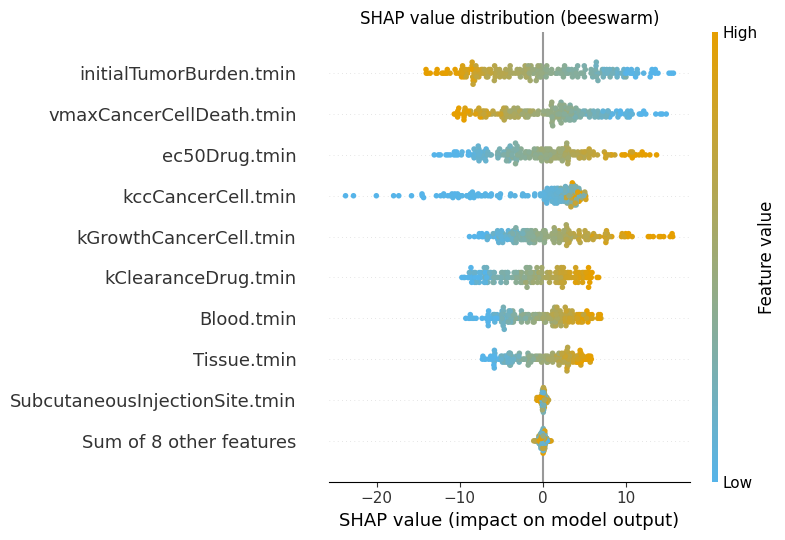

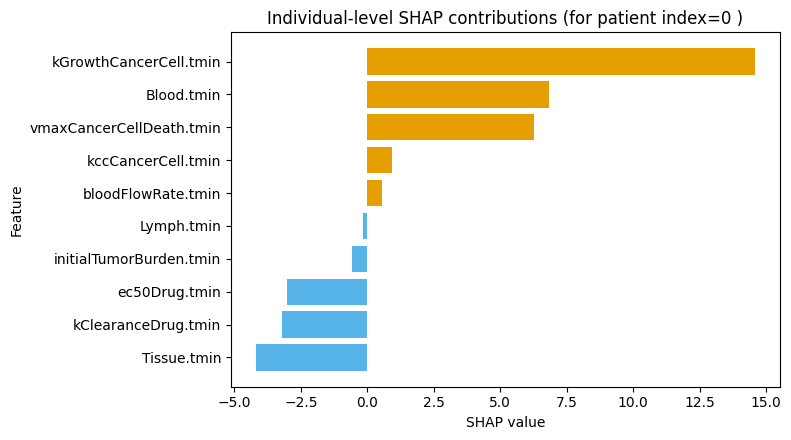

In [83]:
from matplotlib.colors import LinearSegmentedColormap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = (
    pd.DataFrame({"feature": X_train.columns, "mean_abs_shap": mean_abs_shap})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("SHAP global importance (top 10):")
display(shap_importance.head(10))


# Global importance bar chart (Matplotlib)
def plot_shap_importance(importance_df, max_display=10):
    data = importance_df.head(max_display)[::-1]
    fig, ax = plt.subplots(figsize=(9.5, 5.5))
    ax.barh(data["feature"], data["mean_abs_shap"], color="#56b4e9")
    offset = data["mean_abs_shap"].max() * 0.02
    for i, v in enumerate(data["mean_abs_shap"]):
        ax.text(
            v + offset,
            i,
            f"{v:.3g}",
            va="center",
            ha="left",
            fontsize=8,
            color="#4a4a4a",
        )
    ax.set_title("Population-level feature importance (mean |SHAP|)")
    ax.set_xlabel("Mean absolute SHAP value")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    return fig


plot_shap_importance(shap_importance, max_display=10)

# SHAP value distribution (beeswarm)
cmap = LinearSegmentedColormap.from_list("blue_orange", ["#56b4e9", "#e69f00"])
plt.figure(figsize=(8, 5))
try:
    shap.plots.beeswarm(shap_values, max_display=10, color=cmap, show=False)
except Exception:
    shap.summary_plot(
        shap_values,
        X_test,
        plot_type="dot",
        max_display=10,
        show=False,
        color=cmap,
    )
plt.title("SHAP value distribution (beeswarm)")
plt.tight_layout()

# Individual-level explanation (Matplotlib bar for a single patient)
sample_index = 0
local_values = pd.DataFrame(
    {"feature": X_test.columns, "shap_value": shap_values[sample_index].values}
)
local_values["abs_value"] = local_values["shap_value"].abs()
local_values = local_values.sort_values("abs_value", ascending=False).head(10)
local_values = local_values.sort_values("shap_value")
colors = ["#e69f00" if v >= 0 else "#56b4e9" for v in local_values["shap_value"]]

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.barh(local_values["feature"], local_values["shap_value"], color=colors)
ax.set_title("Individual-level SHAP contributions (for patient index=0 )")
ax.set_xlabel("SHAP value")
ax.set_ylabel("Feature")
plt.tight_layout()

## Step 5: Tornado sensitivity comparison

For illustrative purposes, we compared SHAP-based rankings with Tornado sensitivity results from the API.


Tornado ranking (top 10):


,feature,low_effect,high_effect,max_abs_effect
0,initialTumorBurden.tmin,7.308556,-7.466580,7.466580
1,ec50Drug.tmin,-5.623902,5.694117,5.694117
2,vmaxCancerCellDeath.tmin,5.329386,-5.499452,5.499452
3,kGrowthCancerCell.tmin,-5.100353,5.240158,5.240158
4,kccCancerCell.tmin,-4.837061,5.171412,5.171412
5,Blood.tmin,-4.946517,4.304985,4.946517
6,Tissue.tmin,-4.505092,3.719809,4.505092
7,kClearanceDrug.tmin,-4.203368,3.858766,4.203368
8,SubcutaneousInjectionSite.tmin,-1.811751,0.991127,1.811751
9,lymphDrainingRate.tmin,-1.047724,0.368474,1.047724


Rank comparison (lower is more important):


,feature,shap_rank,tornado_rank
0,initialTumorBurden.tmin,1,1
1,vmaxCancerCellDeath.tmin,2,3
2,ec50Drug.tmin,3,2
3,kccCancerCell.tmin,4,5
4,kGrowthCancerCell.tmin,5,4
5,kClearanceDrug.tmin,6,8
6,Blood.tmin,7,6
7,Tissue.tmin,8,7
8,SubcutaneousInjectionSite.tmin,9,9
9,bloodFlowRate.tmin,10,12


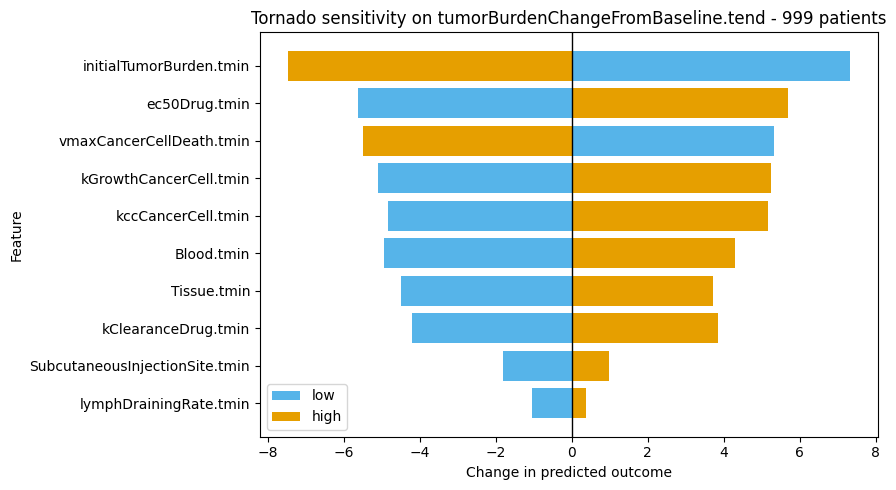

In [84]:
def fetch_tornado_summary(core_id, snapshot_id, target_scalar, arm_ids):
    payload = {
        "equateBaselines": True,
        "filter": [],
        "groupBy": [{"tag": "ScenarioArm"}],
        "inputDescriptors": {"tag": "InputBaselineOnly"},
        "quantile": 0.5,
        "scalars": {target_scalar: arm_ids},
    }
    response = jinko.make_request(
        f"/core/v2/result_manager/trial/{core_id}/snapshots/{snapshot_id}/sensitivity/tornado",
        method="POST",
        data=json.dumps(payload),
    )
    response.raise_for_status()
    return response.json()


def parse_tornado_sensitivities(summary):
    rows = []
    for output in summary.get("outputs", []):
        for sens in output.get("sensitivities", []):
            feature = sens["inputDescriptor"]
            sensitivity = sens["sensitivity"]
            low = sensitivity["mediumLowSensitivity"]
            high = sensitivity["mediumHighSensitivity"]
            rows.append(
                {"feature": feature, "low_effect": low, "high_effect": high})
    return pd.DataFrame(rows)


tornado_summary = fetch_tornado_summary(
    trial_core_item_id, trial_snapshot_id, TARGET_QOI, [TARGET_ARM]
)

try:
    tornado_df = parse_tornado_sensitivities(tornado_summary)
except Exception as exc:
    print(f"Tornado endpoint call failed: {exc}")
    tornado_df = pd.DataFrame()

tornado_df = (
    tornado_df.groupby("feature", as_index=False)[
        ["low_effect", "high_effect"]]
    .mean()
    .assign(
        max_abs_effect=lambda df: df[["low_effect", "high_effect"]]
        .abs()
        .max(axis=1)
    )
    .sort_values("max_abs_effect", ascending=False)
    .reset_index(drop=True)
)

print("Tornado ranking (top 10):")
display(tornado_df.head(10))


# Tornado plot
def plot_tornado(tornado_data, max_display=10, title=None):
    data = tornado_data.head(max_display)[::-1]
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(data["feature"], data["low_effect"], color="#56b4e9", label="low")
    ax.barh(data["feature"], data["high_effect"],
            color="#e69f00", label="high")
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title(title or "Tornado sensitivity")
    ax.set_xlabel("Change in predicted outcome")
    ax.set_ylabel("Feature")
    ax.legend()
    plt.tight_layout()
    return fig


plot_tornado(tornado_df, max_display=10,
             title=f"Tornado sensitivity on {TARGET_QOI} - {len(df_scalars)} patients")


# Compare rankings between SHAP and tornado analysis
rank_comparison = shap_importance[["feature"]].copy()
rank_comparison["shap_rank"] = range(1, len(shap_importance) + 1)
rank_comparison = rank_comparison.merge(
    tornado_df[["feature"]].assign(tornado_rank=range(1, len(tornado_df) + 1)),
    on="feature",
    how="left",
)

print("Rank comparison (lower is more important):")
display(rank_comparison)

## Notes

- SHAP is model-agnostic, but tree models are especially efficient and produce high-quality explanations.
- Use the surrogate model predictions for interpretability, while keeping the underlying simulator as the source of truth.
